In [1]:
from datahandler import *
from playground import *
from gui import *
from torchutils import *
from models import *
from torch.utils.data import WeightedRandomSampler
import matplotlib.pyplot as plt
from gui import visualize_model_outputs
from backtest import *

In [2]:
data = pd.read_csv("BTCUSDT_5m.csv")
data.drop(["Unnamed: 0", "Close Unix"], axis=1, inplace=True)

handler = NewDataHandler(dataset=data)

seq_length = 15

crossover_horizon = 3

device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = torch.load(
f'./models/crossover_{seq_length}_to_{crossover_horizon}.pt').to(device)

ma1, ma2, ma_mode = 5, 10, 'normal'
ma_modes = {'exponential': 'EMA', 'normal': 'MA'}
ma_name = ma_modes[ma_mode]
k1, k2 = 5, 10

handler.data = ma_crossover_labelling(handler.data, ma1, ma2, crossover_horizon, ma_mode)

handler.data = add_kendall_tau(handler.data, k1)
handler.data = add_kendall_tau(handler.data, k2)
handler.data = add_ichimoku(handler.data)
ichimoku_cols = ['ABOVE_ICHIMOKU_9', 'ABOVE_ICHIMOKU_26', 'Close_ICHIMOKU_9_PERC_DIFF', 'Close_ICHIMOKU_26_PERC_DIFF']

handler.add_indicators([Indicators.RSI, Indicators.MACD,
                    Indicators.ADX])

handler.create_var_indicator([Indicators.RSI, Indicators.MACD, Indicators.ADX, Indicators.LOG_RET])

# display(handler.data[handler.data.isnull().any(axis=1)]) # Displaying all the rows that contain missing values to see if they are spread across the dataframe

handler.data.replace([np.inf, -np.inf], 0, inplace=True)

# handler.standardize_data()

handler.data.dropna(axis=0, inplace=True)

handler.create_predict_data()

# handler.data.drop('NTrades', axis=1, inplace=True)

predict_data = handler.predict_data
predict_data['Target'] = handler.data['Label']
predict_data[[f'Kendall_{k1}', f'Kendall_{k2}']] = handler.data[[f'Kendall_{k1}', f'Kendall_{k2}']]
predict_data[f'{ma_name}{ma1} Var'], predict_data[f'{ma_name}{ma2} Var'] = handler.data[f'{ma_name}{ma1} Var'], handler.data[f'{ma_name}{ma2} Var']
predict_data[f'Close_{ma_name}{ma1}_PERC_DIFF'], predict_data[f'Close_{ma_name}{ma2}_PERC_DIFF'] = handler.data[f'Close_{ma_name}{ma1}_PERC_DIFF'], handler.data[f'Close_{ma_name}{ma2}_PERC_DIFF']
predict_data[f'{ma_name}{ma1}_{ma_name}{ma2}_PERC_DIFF'] = handler.data[f'{ma_name}{ma1}_{ma_name}{ma2}_PERC_DIFF']
predict_data[f'{ma_name}{ma1} UP'], predict_data[f'{ma_name}{ma2} UP'] = (handler.data[f'{ma_name}{ma1}'] > handler.data[f'{ma_name}{ma2}']) * 1, (handler.data[f'{ma_name}{ma1}'] < handler.data[f'{ma_name}{ma2}']) * 1
predict_data[ichimoku_cols] = handler.data[ichimoku_cols]
predict_data.reset_index(drop=True, inplace=True)
handler.data.reset_index(drop=True, inplace=True)

Index(['MACD_12_26_9', 'MACDh_12_26_9', 'MACDs_12_26_9'], dtype='object')


C:\Users\Alexis\AppData\Local\Temp\ipykernel_6464\2337945990.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predict_data['Target'] = handler.data['Label']
C:\Users\Alexis\AppData\Local\Temp\ipykernel_6464\2337945990.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predict_data[[f'Kendall_{k1}', f'Kendall_{k2}']] = handler.data[[f'Kendall_{k1}', f'Kendall_{k2}']]
C:\Users\Alexis\AppData\Local\Temp\ipykernel_6464\2337945990.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a s

In [3]:
standardize_cols = predict_data.drop(['Unix', 'RSI_30-', 'RSI_BTW', 'RSI_70+', 'Target', 'MA5 UP', 'MA10 UP', 'ABOVE_ICHIMOKU_9', 'ABOVE_ICHIMOKU_26'], axis=1).columns
scaler = StandardScaler()
predict_data[standardize_cols] = scaler.fit_transform(predict_data[standardize_cols])

C:\Users\Alexis\AppData\Local\Temp\ipykernel_6464\75797144.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predict_data[standardize_cols] = scaler.fit_transform(predict_data[standardize_cols])


In [4]:
predict_data

,Unix,RSI Var,MACD Var,MACD_H Var,ADX Var,-DM Var,+DM Var,RSI_30-,RSI_BTW,RSI_70+,LOG_RET,Target,Kendall_5,Kendall_10,MA5 Var,MA10 Var,Close_MA5_PERC_DIFF,Close_MA10_PERC_DIFF,MA5_MA10_PERC_DIFF,MA5 UP,MA10 UP,ABOVE_ICHIMOKU_9,ABOVE_ICHIMOKU_26,Close_ICHIMOKU_9_PERC_DIFF,Close_ICHIMOKU_26_PERC_DIFF
0,1502965800000,-0.067626,-0.001546,-0.004086,-0.252263,-0.005322,-0.005243,0,0,1,-0.001075,1,1.313675,-0.615474,1.547548,0.093245,-1.244910,-0.573715,0.462962,0,1,1,1,-1.796454,-1.766164
1,1502966100000,-0.206965,-0.002690,0.030844,-0.250385,0.000758,-0.007051,0,1,0,-1.716764,0,0.191638,-0.406935,0.732112,-0.701153,0.687365,0.379373,-0.137169,1,0,1,1,-1.448643,-1.459051
2,1502966400000,-0.101905,-0.002884,0.007237,-0.203535,-0.005556,-0.005488,1,0,0,-0.328797,0,-1.446151,-0.164198,0.576826,-0.813143,1.235554,0.436601,-0.698352,1,0,1,1,-1.305698,-1.400222
3,1502966700000,0.360423,-0.000324,-0.007586,-0.419667,-0.006838,0.000776,0,0,1,3.668798,0,-0.193635,0.691753,0.769621,0.442600,-1.951725,-1.789481,-0.925831,1,0,1,1,-1.973601,-2.055963
4,1502967000000,-0.067626,-0.000851,-0.014069,-0.041262,-0.006022,-0.005432,0,0,1,-0.001075,0,0.528562,1.134647,0.768924,0.651462,-1.641988,-1.669234,-1.081775,1,0,1,1,-1.931642,-2.055963
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
606984,1685640900000,0.100344,-0.003093,-0.010112,0.739907,-0.005762,-0.005705,0,1,0,0.285876,0,-1.383358,-1.216809,-0.181240,0.538509,0.408572,0.425285,0.287248,0,1,1,1,-0.134501,-0.160322
606985,1685641200000,-0.087824,-0.003336,-0.116918,-0.032650,-0.005773,-0.005181,0,1,0,-0.085378,0,-1.040790,-1.216809,-0.601506,-0.445020,0.247360,0.396883,0.431601,0,1,1,1,-0.117062,-0.144891
606986,1685641500000,0.079504,-0.002113,0.000681,-0.779203,-0.005855,-0.004903,0,1,0,0.331055,1,-0.013086,-0.951193,-0.217895,-0.517436,-0.156316,0.092089,0.362045,0,1,1,1,-0.182616,-0.205662
606987,1685641800000,-0.147865,-0.003403,0.007513,-0.993579,-0.005991,-0.005644,0,1,0,-0.328372,1,0.672051,-0.862655,-0.298570,-0.309521,0.036776,0.242208,0.403323,0,1,1,1,-0.114932,-0.145776


In [5]:
#dataset = TSDataset(predict_data, seq_length)
#test_indices = range(round(0.9 * len(dataset)), len(dataset) - seq_length)
#test_set = torch.utils.data.Subset(dataset, test_indices)
#eval_lstm(model, test_set, 64, model.num_layers, model.hidden_size, device)

In [6]:
handler.data = handler.data.drop(range(0, round(0.7 * handler.data.shape[0]))).reset_index(drop=True)
handler.data

,Unix,Open,High,Low,Close,Volume,Quote Asset Volume,NTrades,MA5,MA10,MA5 Var,MA10 Var,Close_MA5_PERC_DIFF,Close_MA10_PERC_DIFF,MA5_MA10_PERC_DIFF,Label,Kendall_5,Kendall_10,ICHIMOKU_9,ICHIMOKU_26,ABOVE_ICHIMOKU_9,ABOVE_ICHIMOKU_26,Close_ICHIMOKU_9_PERC_DIFF,Close_ICHIMOKU_26_PERC_DIFF,RSI,RSI_30-,RSI_BTW,RSI_70+,MACD,MACD_H,ADX,+DM,-DM,RSI Var,MACD Var,MACD_H Var,ADX Var,-DM Var,+DM Var,LOG_RET
0,1630998000000,52334.71,52424.94,52288.00,52311.42,264.67650,1.385850e+07,7684,52435.672,52503.697,-0.001038,-0.000597,0.002375,0.003676,0.001297,0,-1.0,-0.777778,52674.2225,52628.050,0,0,0.006935,0.006053,3.135599,1,0,0,-50.724227,-29.286615,70.801728,2.765238,45.048133,-0.148059,0.383625,0.299063,0.142221,-0.179868,-0.400416,-0.000445
1,1630998300000,52311.43,52327.46,52175.00,52187.00,358.29029,1.872364e+07,11685,52361.996,52461.415,-0.001405,-0.000805,0.003353,0.005258,0.001899,0,-1.0,-0.777778,52652.8900,52628.050,0,0,0.008927,0.008451,1.434108,1,0,0,-71.090100,-39.721991,78.641309,1.657126,56.697208,-0.542636,0.401502,0.356319,0.110726,0.258592,-0.400730,-0.002381
2,1630998600000,52186.99,52212.52,52080.00,52180.06,349.57735,1.823195e+07,11332,52292.834,52423.412,-0.001321,-0.000724,0.002161,0.004664,0.002497,0,-1.0,-0.822222,52612.3900,52646.255,0,0,0.008285,0.008934,1.371826,1,0,0,-86.789744,-44.337308,84.607801,1.088440,61.841447,-0.043430,0.220841,0.116190,0.075870,0.090732,-0.343176,-0.000133
3,1630998900000,52180.06,52270.19,52061.42,52258.59,318.51994,1.661035e+07,8534,52254.356,52394.795,-0.000736,-0.000546,-0.000081,0.002606,0.002688,0,-0.6,-0.866667,52598.5250,52656.135,0,0,0.006505,0.007607,43.224033,0,1,0,-91.836476,-39.507232,71.386608,12.971040,34.148590,30.508402,0.058149,-0.108939,-0.156264,-0.447804,10.917096,0.001504
4,1630999200000,52258.58,52306.89,52222.89,52287.37,254.49360,1.330270e+07,5895,52244.888,52367.532,-0.000181,-0.000520,-0.000812,0.001533,0.002347,1,0.0,-0.777778,52598.5250,52656.135,0,0,0.005951,0.007053,53.963167,0,1,0,-92.448058,-32.095051,52.891086,19.506999,26.883034,0.248453,0.006659,-0.187616,-0.259090,-0.212763,0.503889,0.000551
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
182092,1685640900000,26940.00,26970.62,26939.97,26961.36,102.41833,2.761105e+06,2350,26993.286,27011.632,-0.000208,0.000439,0.001184,0.001865,0.000680,0,-0.8,-0.600000,26906.7900,26881.935,1,1,-0.002024,-0.002946,38.504515,0,1,0,23.696398,0.243776,35.487724,14.294638,38.994322,0.680986,-0.115727,-0.928426,0.180706,-0.178998,-0.178998,0.000793
182093,1685641200000,26961.35,26974.76,26949.13,26955.08,102.61624,2.766267e+06,2790,26974.416,27001.987,-0.000699,-0.000357,0.000717,0.001740,0.001022,0,-0.6,-0.600000,26906.7900,26881.935,1,1,-0.001791,-0.002714,35.351548,0,1,0,20.495669,-2.365562,36.000140,14.635367,31.844539,-0.081886,-0.135072,-10.703823,0.014439,-0.183354,0.023836,-0.000233
182094,1685641500000,26955.08,26980.82,26955.07,26979.83,78.58753,2.119331e+06,2804,26967.648,26990.762,-0.000251,-0.000416,-0.000452,0.000405,0.000857,1,0.0,-0.466667,26907.9150,26881.935,1,1,-0.002666,-0.003628,56.438617,0,1,0,19.728765,-2.505972,30.735786,16.561891,24.950290,0.596496,-0.037418,0.059356,-0.146231,-0.216497,0.131635,0.000918
182095,1685641800000,26979.83,26982.92,26953.33,26955.44,54.86919,1.479609e+06,1972,26958.340,26984.086,-0.000345,-0.000247,0.000108,0.001063,0.000955,1,0.4,-0.422222,26907.9150,26881.935,1,1,-0.001763,-0.002727,38.078776,0,1,0,16.957445,-4.221834,24.823187,13.989710,18.169799,-0.325306,-0.140471,0.684709,-0.192369,-0.271760,-0.155307,-0.000904


In [7]:
predict_data = predict_data.drop(range(0, round(0.7 * predict_data.shape[0]))).reset_index(drop=True)
predict_data

,Unix,RSI Var,MACD Var,MACD_H Var,ADX Var,-DM Var,+DM Var,RSI_30-,RSI_BTW,RSI_70+,LOG_RET,Target,Kendall_5,Kendall_10,MA5 Var,MA10 Var,Close_MA5_PERC_DIFF,Close_MA10_PERC_DIFF,MA5_MA10_PERC_DIFF,MA5 UP,MA10 UP,ABOVE_ICHIMOKU_9,ABOVE_ICHIMOKU_26,Close_ICHIMOKU_9_PERC_DIFF,Close_ICHIMOKU_26_PERC_DIFF
0,1630998000000,-0.104146,0.003157,0.003300,0.561087,-0.005765,-0.006276,1,0,0,-0.162158,0,-1.725927,-1.570963,-0.891940,-0.740879,0.819926,0.838761,0.547594,0,1,0,0,0.537486,0.437431
1,1630998300000,-0.201472,0.003381,0.003925,0.414744,-0.004685,-0.006277,1,0,0,-0.862830,0,-1.725927,-1.570963,-1.205833,-0.998560,1.157689,1.200103,0.801082,0,1,0,0,0.686883,0.596759
2,1630998600000,-0.078339,0.001120,0.001301,0.252785,-0.005099,-0.006128,1,0,0,-0.049203,0,-1.725927,-1.659501,-1.133733,-0.898637,0.746023,1.064348,1.053299,0,1,0,0,0.638734,0.628844
3,1630998900000,7.457496,-0.000917,-0.001158,-0.825822,-0.006424,0.022927,0,1,0,0.543149,0,-1.040790,-1.748040,-0.632967,-0.678186,-0.028360,0.594639,1.133618,0,1,0,0,0.505191,0.540690
4,1630999200000,-0.006344,-0.001561,-0.002018,-1.303596,-0.005846,-0.003943,0,1,0,0.198169,1,-0.013086,-1.570963,-0.158222,-0.646642,-0.280972,0.349603,0.990254,0,1,0,0,0.463640,0.503850
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
182092,1685640900000,0.100344,-0.003093,-0.010112,0.739907,-0.005762,-0.005705,0,1,0,0.285876,0,-1.383358,-1.216809,-0.181240,0.538509,0.408572,0.425285,0.287248,0,1,1,1,-0.134501,-0.160322
182093,1685641200000,-0.087824,-0.003336,-0.116918,-0.032650,-0.005773,-0.005181,0,1,0,-0.085378,0,-1.040790,-1.216809,-0.601506,-0.445020,0.247360,0.396883,0.431601,0,1,1,1,-0.117062,-0.144891
182094,1685641500000,0.079504,-0.002113,0.000681,-0.779203,-0.005855,-0.004903,0,1,0,0.331055,1,-0.013086,-0.951193,-0.217895,-0.517436,-0.156316,0.092089,0.362045,0,1,1,1,-0.182616,-0.205662
182095,1685641800000,-0.147865,-0.003403,0.007513,-0.993579,-0.005991,-0.005644,0,1,0,-0.328372,1,0.672051,-0.862655,-0.298570,-0.309521,0.036776,0.242208,0.403323,0,1,1,1,-0.114932,-0.145776


In [8]:
target_return = 0.003

In [9]:
# visualize_model_outputs(handler.data, predict_data, model, seq_length, device, True, target_return=target_return, ratio=2)

99.990115158404594654
 -2    4378
 2    2768
 1     474
-1     201
Name: count, dtype: int64 7821


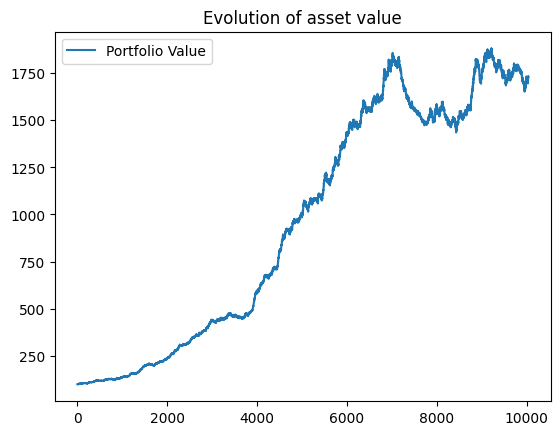

In [10]:
baseline_crossover(handler.data, predict_data, seq_length, noise_threshold=0.3, target_return=target_return, ratio=2)

99.991762632003834358
 -2    4445
 2    1893
 1     449
-1     166
Name: count, dtype: int64 6953


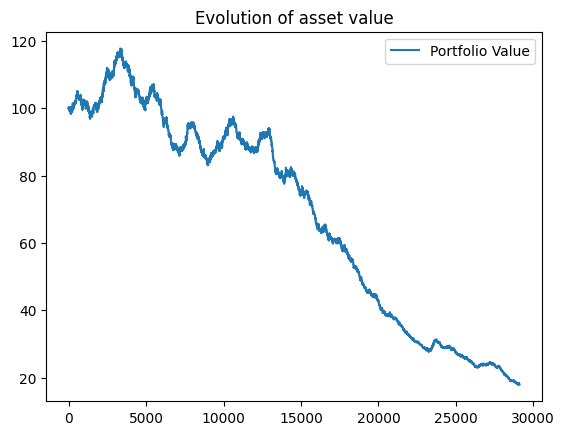

In [11]:
backtest_crossover(handler.data, predict_data, model, seq_length, device, target_return=target_return, ratio=2)

In [12]:
backtest_crossover_v2(handler.data, predict_data, model, seq_length, device, target_return=target_return, ratio=2)